Analysis Pipeline for Evaluation Data

This notebook documents the pipeline used to analyze the evaluation data for the scientific paper *Investigating Student Interaction with Competency-Based CS Education*. The analysis focuses on extracting insights into the effectiveness and impact of *Atlas*, a CBE learning analytics system, on student's learning process.

## Objectives
- **Data Cleaning and Preprocessing:** Standardize and clean the raw data collected from the Learning Management System (LMS) and surveys.
- **Descriptive Statistics:** Summarize key metrics, such as student engagement, performance, and competency mastery.
- **Inferential Analysis:** Apply statistical tests to evaluate the significance of observed outcomes.
- **Visualization:** Generate clear and insightful plots to highlight trends and findings.

## Tools and Libraries
This analysis leverages Python's robust data science ecosystem, including:
- `pandas` for data loading, cleaning, and reshaping
- `matplotlib` for flexible plotting and export
- `plot_likert` for clear Likert-scale visualizations
- `pingouin` for inferential statistics and effect sizes
- `numpy` for fast vectorized numerical operations
- `os` for reliable file and path handling

Each section of this notebook corresponds to a specific stage of the analysis pipeline, ensuring clarity and reproducibility.

# Imports
In the first step, we import all necessary libraries and load the datasets required for the analysis.

## Libraries and Functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plot_likert as pl
import pingouin as pg
import os
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.contingency_tables import Table2x2

## Data

### System Data
Load all relevant system log datasets needed for the data exploration.

In [2]:
competency_df = pd.read_csv('data/01_anonymized/competency.csv')
competency_exercise_mapping_df = pd.read_csv('data/01_anonymized/competency_exercise.csv')
competency_unit_mapping_df = pd.read_csv('data/01_anonymized/competency_lecture_unit.csv')
competency_user_df = pd.read_csv('data/01_anonymized/competency_user.csv')
exam_score_df = pd.read_csv('data/01_anonymized/participant_score_exam.csv')
exercise_df = pd.read_csv('data/01_anonymized/exercise.csv')
learning_path_df = pd.read_csv('data/01_anonymized/learning_path.csv')
lecture_df = pd.read_csv('data/01_anonymized/lecture.csv')
participation_df = pd.read_csv('data/01_anonymized/participation.csv')
participant_score_df = pd.read_csv('data/01_anonymized/participant_score.csv')
science_event_df = pd.read_csv('data/01_anonymized/science_event.csv')
units_df = pd.read_csv('data/01_anonymized/lecture_unit.csv')

### Survey Data
Load the pre- and post-survey datasets.

In [3]:
pre_survey_df = pd.read_csv('data/01_anonymized/lime_survey_pre.csv')
post_survey_df = pd.read_csv('data/01_anonymized/lime_survey_post.csv')

# Data Cleaning and Preprocessing
After the data is loaded, it is crucial to preprocess it to ensure consistency and relevance for the analysis.

## Remove all Science Events that are not related to the relevant course
The science_event_df contains events from multiple courses. We filter it to retain only those events that are relevant to our specific course of interest.

In [4]:
# Define all relevant resources
# Course
course_id = 443
# Exercises
exercise_ids = exercise_df['id'].dropna().unique()
# Competencies
competency_ids = competency_df['id'].dropna().unique()
# Units
unit_ids = units_df['id'].dropna().unique()

## Filter science_event_df for relevant events
science_event_df = science_event_df[
    (
        ((science_event_df['event_type'] == 1) & science_event_df['resource_id'].isin(unit_ids))
        |
        ((science_event_df['event_type'] == 2) & science_event_df['resource_id'].isin(exercise_ids))
        |
        ((science_event_df['event_type'] == 3) & science_event_df['resource_id'].isin(competency_ids))
        |
        ((science_event_df['event_type'] == 4) & (science_event_df['resource_id'] == course_id))
        |
        (science_event_df['event_type'].isin([5, 6, 7, 8, 9]))
    )
]

## Rename Columns
For consistency across datasets, we rename certain columns to have uniform naming conventions, especially for user identifiers. For better clarity, we also rename the analyzed survey question columns to more descriptive names.

In [5]:
participation_df = participation_df.rename(columns={'student_id': 'user_id'})
science_event_df = science_event_df.rename(columns={'identity': 'user_id'})
pre_survey_df = pre_survey_df.rename(columns={
        'uuid': 'user_id',
        'G01Q08': 'Degree',
        'G03Q07': 'Subject',
        'G02Q09': 'Semester',
        'G03Q10': 'Age',
        'G03Q11': 'Gender',
    })
post_survey_df = post_survey_df.rename(
    columns={
        'uuid': 'user_id',
        'G02Q05': 'Usability',
        'G02Q06': 'Transparency',
        'G03Q13': 'Confidence',
        'G03Q12[SQ005]': 'Frustration',
        'G04Q15': 'Participation',
        'G05Q16': 'Degree',
        'G05Q17': 'Subject',
        'G05Q18': 'Semester',
        'G05Q19': 'Age',
        'G05Q20': 'Gender',
    }
)

## Rename Answers
The survey responses have answer codes. For better readability, these are mapped to the answers in natural language.

### Create Answercode mappings

In [6]:
# Answercode mappings
participation_mapping = {
    'AO01': 'Yes',
    'AO02': 'No',
}

degree_mapping = {
    'AO01': 'Bachelor',
    'AO02': 'Master',
}
subject_mapping = {
    'AO01': 'Computer Science',
    'AO02': 'Information Systems',
    'AO03': 'Games Engineering',
    'AO04': 'Management and Technology',
    'AO05': 'Other',
    'AO06': 'Management and Technology',
}
semester_mapping = {
    'AO01': '1',
    'AO02': '2',
    'AO03': '3',
    'AO04': '4',
    'AO05': '5',
    'AO06': '6',
    'AO07': '7',
    'AO08': '8',
    'AO09': '9+',
}
age_mapping = {
    'AO01': '18',
    'AO02': '19',
    'AO03': '20',
    'AO04': '21',
    'AO05': '22',
    'AO06': '23',
    'AO07': '24',
    'AO08': '25',
}
gender_mapping = {
    'AO01': 'Female',
    'AO02': 'Male',
    'AO03': 'Other',
}


### Apply Mapping to Pre-Survey

In [7]:
# Apply mappings
pre_survey_df['Degree'] = pre_survey_df['Degree'].map(lambda x: degree_mapping.get(x, x))
pre_survey_df['Subject'] = pre_survey_df['Subject'].map(lambda x: subject_mapping.get(x, x))
pre_survey_df['Semester'] = pre_survey_df['Semester'].map(lambda x: semester_mapping.get(x, x))
pre_survey_df['Age'] = pre_survey_df['Age'].map(lambda x: age_mapping.get(x, x))
pre_survey_df['Gender'] = pre_survey_df['Gender'].map(lambda x: gender_mapping.get(x, x))

### Apply Mapping to Post-Survey

In [8]:
# Apply mappings
post_survey_df['Participation'] = post_survey_df['Participation'].map(lambda x: participation_mapping.get(x, x))
post_survey_df['Degree'] = post_survey_df['Degree'].map(lambda x: degree_mapping.get(x, x))
post_survey_df['Subject'] = post_survey_df['Subject'].map(lambda x: subject_mapping.get(x, x))
post_survey_df['Semester'] = post_survey_df['Semester'].map(lambda x: semester_mapping.get(x, x))
post_survey_df['Age'] = post_survey_df['Age'].map(lambda x: age_mapping.get(x, x))
post_survey_df['Gender'] = post_survey_df['Gender'].map(lambda x: gender_mapping.get(x, x))

## Filter the dataset to observations without missing values.
To ensure the integrity of the analysis, we remove rows with missing values in critical columns. This step is essential to avoid skewed results due to incomplete data.

### Remove Empty Rows
Empty rows in the survey dataframes are surveys that were started but not submitted. We remove these rows to ensure that only completed surveys are analyzed.

In [9]:
pre_survey_df = pre_survey_df.dropna(subset=[col for col in pre_survey_df.columns if col != "user_id"], how='all')
post_survey_df = post_survey_df.dropna(subset=[col for col in post_survey_df.columns if col != "user_id"], how='all')

### Remove rows where _user_id_ is _NOT_FOUND_
Rows where the user_id is NOT_FOUND cannot be mapped to a specific student. Therefore, these rows are removed from all datasets.

In [10]:
competency_user_df = competency_user_df[competency_user_df["user_id"] != "NOT_FOUND"].copy()
participant_score_df = participant_score_df[participant_score_df["user_id"] != "NOT_FOUND"].copy()
participation_df = participation_df[participation_df["user_id"] != "NOT_FOUND"].copy()
pre_survey_df = pre_survey_df[pre_survey_df['user_id'] != 'NOT_FOUND'].copy()
post_survey_df = post_survey_df[post_survey_df['user_id'] != 'NOT_FOUND'].copy()

## Fill Missing Demographic Data in the Post-Survey from the Pre-Survey
Students who have participated in the pre-survey were not asked the demographic questions again in the post-survey. To ensure that the demographic data is complete in the post-survey, we fill in any missing demographic information from the pre-survey based on the user_id.

In [11]:
pre  = pre_survey_df.copy()
post = post_survey_df.copy()

# Demographic columns to transfer
demo_cols = ['Degree', 'Subject', 'Semester', 'Age', 'Gender']

# For each demographic column, build a lookup from pre and fill post
# - drop_duplicates keeps the first occurrence per user_id
for col in demo_cols:
    lookup = pre.drop_duplicates('user_id').set_index('user_id')[col]
    post[col] = post[col].fillna(post['user_id'].map(lookup))

# Result back into the initial dataframe:
post_survey_df = post

## Function for Data Filtering
For the following analysis, we often need to filter the science_event_df for specific event types. To streamline this process, we define a function that takes a list of event types and returns a filtered DataFrame containing only those events.

In [12]:
## Filter table science_event for relevant data
def filter_for_relevant_events(event_types):
    """
    Filter the global `science_event_df` to rows matching the given event type(s).

    Parameters
    ----------
    event_types : sequence (list/tuple/array-like)
        One or more event_type codes to keep (e.g., [5, 6, 7] or [5]).

    Returns
    -------
    pd.DataFrame
        Subset of `science_event_df` containing only the requested event types.
    """
    # Work on a copy to avoid modifying the original DataFrame
    filtered = science_event_df.copy()

    # For a single type, use equality; for multiple types, use .isin(...)
    if len(event_types) == 1:
        return filtered[filtered['event_type'] == event_types[0]]
    else:
        return filtered[filtered['event_type'].isin(event_types)]


## Add Week Columns
For temporal analyses, it is beneficial to have a 'week' column that indicates the week number of each event based on its timestamp. This function adds such a column to the DataFrame.


In [13]:
## Add week column
def add_week(dataframe):
    """
    Add an ISO week number column ('week') derived from a 'timestamp' column.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Input table containing a 'timestamp' column (string, datetime, or pandas-compatible).

    Returns
    -------
    pd.DataFrame
        The same DataFrame with an added 'week' column (ISO week: 1-53; dtype UInt32).
    """
    # Ensure 'timestamp' is datetime
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'])

    # Extract ISO week number
    dataframe['week'] = dataframe['timestamp'].dt.isocalendar().week

    return dataframe


In [14]:
## Add week column where needed for later analysis
science_event_df = add_week(science_event_df)

## Map Exercises and Units to Competencies
To facilitate the analyses that focus on competencies, we map exercises and lecture units to their corresponding competency IDs. This mapping allows us to analyze user interactions at the competency level.

In [15]:
def resolve(row):
    """
    Resolve a single event row to a competency_id based on its event_type.

    Parameters
    ----------
    row : pd.Series
        A row with at least 'event_type' and 'resource_id' fields.

    Returns
    -------
    object or numpy.nan
        The resolved competency_id if it can be determined; otherwise NaN.

    Notes
    -----
    Uses global lookup maps:
      - map_unit:      unit_id -> competency_id       (for event_type == 1)
      - map_exercise:  exercise_id -> competency_id   (for event_type == 2)
      - event_type in {3, 4}: resource_id is already a competency_id
    """
    et, rid = row.event_type, row.resource_id

    # Unit event -> lookup unit_id in map_unit
    if et == 1:
        return map_unit.get(rid, np.nan)

    # Exercise event -> lookup exercise_id in map_exercise
    elif et == 2:
        return map_exercise.get(rid, np.nan)

    # Already a competency event -> pass through the resource_id
    elif et in (3, 4):
        return rid

    # Non-mappable event types -> no competency mapping, e.g. interactions with the learning path
    else:
        return np.nan


In [16]:
# Create mapping dictionaries
map_unit     = competency_unit_mapping_df.set_index('lecture_unit_id')['competency_id'].to_dict()
map_exercise = competency_exercise_mapping_df.set_index('exercise_id')['competency_id'].to_dict()

science_event_df["competency_id"] = science_event_df.apply(resolve, axis=1)
science_event_df.to_csv("data/02_output/science_event_with_comp.csv", index=False)

## General Data
For the temporal analyses, we need to determine the start date of the course. This date serves as a reference point for calculating relative weeks.

In [17]:
start_date = pd.to_datetime(science_event_df['timestamp'].min())
start_date

Timestamp('2025-04-25 06:52:44')

## User Mapping
To analyse the system and survey data based on user interactions, we create a comprehensive user mapping. This mapping includes all unique users from the relevant datasets and classifies them based on their interaction levels with the competencies.

In [18]:
# Collect all unique user_ids from relevant datasets
all_user_ids = pd.concat([
    competency_user_df[['user_id']],
    learning_path_df[['user_id']],
    participant_score_df[['user_id']],
    participation_df[['user_id']],
    science_event_df[['user_id']]
])

# Remove the "NOT_FOUND" user_ids
all_user_ids = all_user_ids.loc[all_user_ids['user_id'] != "NOT_FOUND"]

# Remove duplicates to get unique user_ids
unique_users_df = all_user_ids.drop_duplicates().reset_index(drop=True)

# Show the number of unique users
print(f"Number of unique users: {len(unique_users_df)}")

Number of unique users: 1278


In [19]:
def classify_interaction_group(count):
    """
    Classify a user into an interaction group based on their interaction count.

    Parameters
    ----------
    count : int or float
        Number of interactions observed for the user.

    Returns
    -------
    str
        One of {'No', 'Low', 'High'}:
          - 'No'   if count == 0
          - 'Low'  if 1 <= count <= median_interaction_count
          - 'High' if count  >  median_interaction_count
    """
    if count == 0:
        return 'No'
    elif count <= median_interaction_count:
        return 'Low'
    else:
        return 'High'


In [20]:
# Collect interactions with the competencies per user to classify users into groups
# We focus on event_type 3 (Competency open)

# Filter for relevant events
relevant_event_types = [3]  # Event type 3 = Competency open
interaction_competencies_df = filter_for_relevant_events(relevant_event_types)

# Count interactions per user
interaction_counts = interaction_competencies_df['user_id'].value_counts().to_dict()

# Add interaction counts to unique_users_df
unique_users_df['interaction_count'] = unique_users_df['user_id'].apply(lambda uid: interaction_counts.get(uid, 0))

# Filter out users with zero interactions for median calculation
active_users_df = unique_users_df[unique_users_df['interaction_count'] > 0]

# Calculate general statistics about interaction count among active users
min_interaction_count = active_users_df['interaction_count'].min()
print(f"Minimum interaction of users with the competencies: {min_interaction_count}")
max_interaction_count = active_users_df['interaction_count'].max()
print(f"Maximum interaction of users with the competencies: {max_interaction_count}")
mean_interaction_count = active_users_df['interaction_count'].mean()
print(f"Mean interaction of users with the competencies: {mean_interaction_count}")
sd_interaction_count = active_users_df['interaction_count'].std()
print(f"Standard deviation interaction of users with the competencies: {sd_interaction_count}")


# Calculate the median interaction count among active users
median_interaction_count = active_users_df['interaction_count'].median()
print(f"Median interaction of users with the competencies: {median_interaction_count}")

unique_users_df['interaction_group'] = unique_users_df['interaction_count'].apply(classify_interaction_group)
unique_users_df.to_csv('data/01_anonymized/user_mapping.csv', index=False)

Minimum interaction of users with the competencies: 1
Maximum interaction of users with the competencies: 79
Mean interaction of users with the competencies: 4.308196721311475
Standard deviation interaction of users with the competencies: 6.803608988251298
Median interaction of users with the competencies: 2.0


In [21]:
# Count the number of users per interaction group
number_of_users_group_no = (unique_users_df['interaction_group'] == 'No').sum()
number_of_users_group_low = (unique_users_df['interaction_group'] == 'Low').sum()
number_of_users_group_high = (unique_users_df['interaction_group'] == 'High').sum()

print("Number of users in the 'No' group:", number_of_users_group_no)
print("Number of users in the 'Low' group:", number_of_users_group_low)
print("Number of users in the 'High'group:", number_of_users_group_high)


Number of users in the 'No' group: 668
Number of users in the 'Low' group: 329
Number of users in the 'High'group: 281


In [22]:
def add_interaction_group(df):
    """
    Add each user's interaction group and a binary 'interaction' flag to the input DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Table that contains a 'user_id' column to join on.

    Returns
    -------
    pd.DataFrame
        A copy of `df` with:
          - 'interaction_group' joined from `unique_users_df`
          - 'interaction' flag: 'yes' for High/Low, 'no' otherwise (incl. NaN)
    """
    # Two-column mapping from the user registry
    group_mapping = unique_users_df[["user_id", "interaction_group"]]

    # Left join: keep all rows from df; attach group where available
    df = df.merge(group_mapping, on="user_id", how="left")

    # Derive a simple interaction flag from the group label
    df["interaction"] = np.where(df["interaction_group"].isin(["High", "Low"]), "yes", "no")

    return df


In [23]:
# Add the interaction group to all relevant datasets
exam_score_df = add_interaction_group(exam_score_df)
science_event_df = add_interaction_group(science_event_df)
participant_score_df = add_interaction_group(participant_score_df)
post_survey_df = add_interaction_group(post_survey_df)
competency_user_df = add_interaction_group(competency_user_df)
participation_df = add_interaction_group(participation_df)
learning_path_df = add_interaction_group(learning_path_df)

# Data Analysis

## Demographics Analysis
We start the analysis by examining the demographic characteristics of the survey participants. This includes summarizing key variables such as degree program, subject area, semester, age

In [24]:
def make_table(pre: pd.DataFrame, post: pd.DataFrame, variables):
    """
    Build a simple summary table for selected variables with counts and percentages
    for pre- and post-survey data.

    Parameters
    ----------
    pre, post : pd.DataFrame
        DataFrames containing the variables to summarize.
    variables : list-like
        Column names to include (e.g., ["Degree", "Subject", "Semester"]).

    Returns
    -------
    pd.DataFrame
        A two-column summary per variable showing "count (percent)" for pre/post.
    """
    rows = []
    for var in variables:
        # Take non-missing values for the current variable
        pre_s, post_s = pre[var].dropna(), post[var].dropna()
        n_pre, n_post = len(pre_s), len(post_s)

        # Frequency counts per response level
        c_pre, c_post = pre_s.value_counts(), post_s.value_counts()

        # All levels seen in either pre or post; keep the order as they first appear
        levels = list(dict.fromkeys(list(c_pre.index) + list(c_post.index)))

        # Add a header row for this variable (blank cells for readability)
        rows.append({"Variable": var, "Pre-Survey": "", "Post-Survey": ""})

        # Add one row per level with "count (percent)" for pre and post
        for lvl in levels:
            p = int(c_pre.get(lvl, 0))   # pre count for this level (0 if absent)
            q = int(c_post.get(lvl, 0))  # post count for this level (0 if absent)

            # Percentages are relative to non-missing counts; guard against n=0
            pre_cell  = f"{p} ({(p/n_pre*100 if n_pre else 0):.2f}%)"
            post_cell = f"{q} ({(q/n_post*100 if n_post else 0):.2f}%)"

            rows.append({
                "Variable": f"  {lvl}",  # indent level label under the variable
                "Pre-Survey": pre_cell,
                "Post-Survey": post_cell
            })

    return pd.DataFrame(rows)


In [25]:
# Create Demographics Table
vars_ = ["Degree", "Subject", "Semester", "Age", "Gender"]
table = make_table(pre_survey_df, post_survey_df, vars_)
table

,Variable,Pre-Survey,Post-Survey
0,Degree,,
1,Bachelor,84 (97.67%),58 (100.00%)
2,Master,2 (2.33%),0 (0.00%)
3,Subject,,
4,Computer Science,73 (83.91%),48 (82.76%)
5,Information Systems,6 (6.90%),4 (6.90%)
6,Other,4 (4.60%),4 (6.90%)
7,Management and Technology,4 (4.60%),2 (3.45%)
8,Semester,,
9,2,65 (75.58%),40 (70.18%)


## Descriptive Analysis
The evaluation section addresses the core research questions of the thesis. The evaluation is structured into the three main areas of interest, each corresponding to a specific research question: Perception, Interaction, and effect on exercise Engagement and Completion.

### Performance
*Research Question 1:* How does the level of interaction with Atlas relate to student performance on assessments?

#### Mastery Score
We analyse the mastery score as a measure of performance.

In [26]:
# Build the Cartesian product of all users × all competencies
all_combinations = unique_users_df.merge(
    competency_df,
    how="cross"
)
# Rename the generic competency 'id' to 'competency_id' for clarity and joins
all_combinations = all_combinations.rename(columns={'id': 'competency_id'})

# Merge with existing user-competency records to bring in progress/confidence where available
full_df = all_combinations.merge(
    competency_user_df,
    on=["user_id", "competency_id"],
    how="left"  # keep every user-competency pair even if no record exists yet
)

# Fill missing progress/confidence with 0 (interpreted as not started / no confidence reported)
full_df["progress"] = full_df["progress"].fillna(0)
full_df["confidence"] = full_df["confidence"].fillna(0)

# Remove duplicate interaction_group columns produced by merges
full_df = full_df.drop(columns=["interaction_group_x", "interaction_group_y"])

# Compute a single interaction_group column based on the current data
full_df = add_interaction_group(full_df)


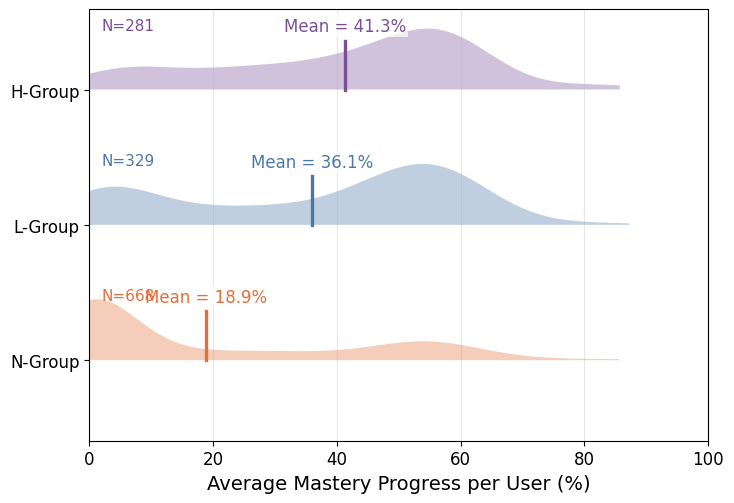

In [27]:
# Set global font sizes
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# Column names and styling
USER_COL = 'user_id'
GROUP_COL = 'interaction_group'
COMP_COL  = 'competency_id'
GROUP_ORDER  = ['No', 'Low', 'High']
GROUP_COLORS = {'No': '#E0703C', 'Low': '#4C78A8', 'High': '#7A5195'}
LABEL_MAP = {'No': 'N-Group', 'Low': 'L-Group', 'High': 'H-Group'}

# Map each user to a single interaction group
group_map = (full_df[[USER_COL, GROUP_COL]]
             .drop_duplicates(subset=[USER_COL])
             .set_index(USER_COL)[GROUP_COL])

# Compute mastery and normalized progress (0-1)
full_df['mastery'] = (full_df['progress'] * full_df['confidence']).clip(0, 100)
full_df['mastery_progress'] = (full_df['mastery'] / full_df['mastery_threshold']).clip(0, 1)

# For each (user, competency) take max; then average per user
max_mp_per_comp = full_df.groupby([USER_COL, COMP_COL], as_index=False)['mastery_progress'].max()
avg_mp_per_user = max_mp_per_comp.groupby(USER_COL)['mastery_progress'].mean().rename('avg_mastery_progress')

# Join averages with group labels
plot_df = avg_mp_per_user.to_frame().join(group_map, how='inner')

# Prepare per-group arrays in percent
vals_by_group = {
    g: (plot_df.loc[plot_df[GROUP_COL] == g, 'avg_mastery_progress'].values * 100.0)
    for g in GROUP_ORDER
}
vals_by_group = {g: v for g, v in vals_by_group.items() if v.size > 0}

# Half-violin plot
fig, ax = plt.subplots(figsize=(7.5, 5.2))
ypos = {g: i for i, g in enumerate(vals_by_group.keys())}
data = [vals_by_group[g] for g in vals_by_group.keys()]
pos  = [ypos[g] for g in vals_by_group.keys()]

vp = ax.violinplot(dataset=data, positions=pos, vert=False,
                   showmeans=False, showmedians=False, showextrema=False, widths=0.9)

# Keep upper half and color by group
for body, g in zip(vp['bodies'], vals_by_group.keys()):
    verts = body.get_paths()[0].vertices
    y0 = ypos[g]
    verts[:, 1] = np.maximum(verts[:, 1], y0)
    body.set_facecolor(GROUP_COLORS.get(g, '0.5'))
    body.set_edgecolor('none')
    body.set_alpha(0.35)

# Add mean tick and label per group
for g, v in vals_by_group.items():
    y = ypos[g]
    mean = float(np.mean(v))
    ax.plot([mean, mean], [y, y + 0.36],
            linewidth=2.4, color=GROUP_COLORS.get(g, '0.5'), zorder=5)
    ax.text(mean, y + 0.40, f"Mean = {mean:.1f}%",
            ha='center', va='bottom', fontsize=12,
            color=GROUP_COLORS.get(g, '0.5'),
            bbox=dict(facecolor='white', alpha=0.75, edgecolor='none', pad=1.5))

# Axis labels and grid
ax.set_yticks(list(ypos.values()))
ax.set_yticklabels([LABEL_MAP[g] for g in vals_by_group.keys()])
ax.set_xlim(0, 100)
ax.set_xlabel('Average Mastery Progress per User (%)')
ax.grid(True, axis='x', alpha=0.3)

# Annotate N per group
xmin = ax.get_xlim()[0]; pad = 2
for g, v in vals_by_group.items():
    ax.text(xmin + pad, ypos[g] + 0.42, f"N={len(v)}",
            color=GROUP_COLORS.get(g, '0.5'),
            va='bottom', ha='left', fontsize=11)

fig.tight_layout()

# Save and show
out_path = "data/02_output/mastery.pdf"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
fig.savefig(out_path, format="pdf", bbox_inches="tight")
plt.show()


#### Exam Score
We analyse the exam score as a measure of performance.

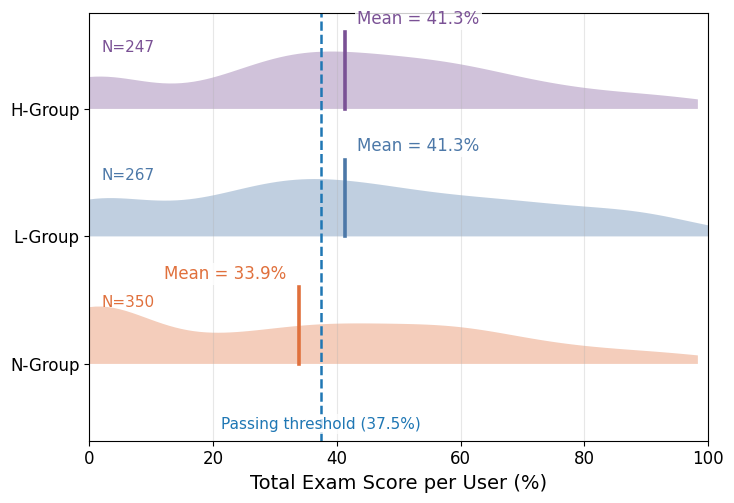

In [28]:
# Set global font sizes for consistent styling
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# Column names and plotting style
USER_COL   = 'user_id'
GROUP_COL  = 'interaction_group'
POINTS_COL = 'last_rated_points'
GROUP_ORDER  = ['No', 'Low', 'High']
GROUP_COLORS = {'No': '#E0703C', 'Low': '#4C78A8', 'High': '#7A5195'}
LABEL_MAP = {'No': 'N-Group', 'Low': 'L-Group', 'High': 'H-Group'}

# Exam scoring constants and pass threshold (in %)
TOTAL_POINTS = 120
PASS_POINTS  = 45
PASS_PCT     = 100 * PASS_POINTS / TOTAL_POINTS  # 37.5

# Total exam score per user; keep group label
df = exam_score_df[[USER_COL, GROUP_COL, POINTS_COL]].copy()
df[POINTS_COL] = df[POINTS_COL].fillna(0)

# Sum points across items per user, then convert to percentage
total_exam = df.groupby(USER_COL, as_index=True)[POINTS_COL].sum().rename('total_exam_score')
total_exam_pct = (total_exam / TOTAL_POINTS * 100).rename('total_exam_pct')

# Attach each user's group to the percentage scores
groups  = df.drop_duplicates(subset=[USER_COL]).set_index(USER_COL)[GROUP_COL]
plot_df = total_exam_pct.to_frame().join(groups, how='inner')

# Build arrays of percentages by group
vals_by_group = {
    g: plot_df.loc[plot_df[GROUP_COL] == g, 'total_exam_pct'].values
    for g in GROUP_ORDER
}
vals_by_group = {g: v for g, v in vals_by_group.items() if v.size > 0}

# Half-violin plot (horizontal)
fig, ax = plt.subplots(figsize=(7.5, 5.2))
ypos = {g: i for i, g in enumerate(vals_by_group.keys())}
data = [vals_by_group[g] for g in vals_by_group.keys()]
pos  = [ypos[g] for g in vals_by_group.keys()]

vp = ax.violinplot(dataset=data, positions=pos, vert=False,
                   showmeans=False, showmedians=False, showextrema=False, widths=0.9)

# Keep upper half of each violin and color by group
for body, g in zip(vp['bodies'], vals_by_group.keys()):
    verts = body.get_paths()[0].vertices
    y0 = ypos[g]
    verts[:, 1] = np.maximum(verts[:, 1], y0)
    body.set_facecolor(GROUP_COLORS[g])
    body.set_edgecolor('none')
    body.set_alpha(0.35)

# Axes, labels, and grid (0-100%)
ax.set_yticks(list(ypos.values()))
ax.set_yticklabels([LABEL_MAP[g] for g in vals_by_group.keys()])
ax.set_xlim(0, 100)
ax.set_xlabel('Total Exam Score per User (%)')
ax.grid(True, axis='x', alpha=0.3)

# Passing threshold line and label
line = ax.axvline(PASS_PCT, linestyle='--', linewidth=1.8)
ymin, ymax = ax.get_ylim()
label_y = ymin + 0.02 * (ymax - ymin)
ax.text(
    PASS_PCT, label_y, f'Passing threshold ({PASS_PCT:.1f}%)',
    ha='center', va='bottom', rotation=0, color=line.get_color(),
    fontsize=11,
    bbox=dict(facecolor='white', alpha=0.75, edgecolor='none', pad=1.5)
)

# Mean tick per group with label placed near the tick
mean_tick_height = 0.60
offset = 2.0
xmin, xmax = ax.get_xlim()

for g, vals in vals_by_group.items():
    y = ypos[g]
    mean = float(np.mean(vals))
    ax.plot([mean, mean], [y, y + mean_tick_height],
            linewidth=2.6, color=GROUP_COLORS[g], zorder=6)

    # Place label to the right or left of the tick
    if g in ('High', 'Low'):
        x_label = min(mean + offset, xmax - 1)
        ha = 'left'
    else:
        x_label = max(mean - offset, xmin + 1)
        ha = 'right'

    ax.text(x_label, y + mean_tick_height + 0.035,
            f"Mean = {mean:.1f}%",
            ha=ha, va='bottom', fontsize=12,
            color=GROUP_COLORS[g],
            bbox=dict(facecolor='white', alpha=0.80, edgecolor='none', pad=1.5))

# Annotate sample size per group
pad = 2
for g, v in vals_by_group.items():
    ax.text(xmin + pad, ypos[g] + 0.42, f"N={len(v)}",
            color=GROUP_COLORS[g], va='bottom', ha='left', fontsize=11)

fig.tight_layout()

# Save to PDF and show
out_path = "data/02_output/exam.pdf"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
fig.savefig(out_path, format="pdf", bbox_inches="tight")
plt.show()


#### Passing Rate in the Exam
We analyse the passing rate as a measure of performance.

In [29]:
# Set relevant variables
USER_COL   = 'user_id'
GROUP_COL  = 'interaction_group'
POINTS_COL = 'last_rated_points'
GROUP_ORDER = ['High', 'Low', 'No']
PASSING_THRESHOLD = 45

# Total exam score per user
df = exam_score_df[[USER_COL, GROUP_COL, POINTS_COL]].copy()
df[POINTS_COL] = df[POINTS_COL].fillna(0)

total_exam = df.groupby(USER_COL, as_index=True)[POINTS_COL].sum().rename('total_exam_score')
groups     = df.drop_duplicates(subset=[USER_COL]).set_index(USER_COL)[GROUP_COL]

users = total_exam.to_frame().join(groups, how='inner').reset_index()

# Evaluate whether the user passed
users['passed'] = users['total_exam_score'] >= PASSING_THRESHOLD

# Percent passed per group
summary = (users.groupby(GROUP_COL)
           .agg(n_users=(USER_COL, 'size'),
                passed_n=('passed', 'sum'))
           .reindex(GROUP_ORDER))
summary['passed_pct'] = (summary['passed_n'] / summary['n_users'] * 100).round(1)

print(summary)


                   n_users  passed_n  passed_pct
interaction_group                               
High                   247       137        55.5
Low                    267       141        52.8
No                     350       160        45.7


### Engagement and Motivation
*Research Question 2:* How does the level of interaction with Atlas relate to student engagement and motivation?

#### Practice Mode
We analyse the usage of the practice mode as a measure of engagement and motivation

In [30]:
df = participation_df.copy()

# Total number of test runs per interaction group (booleans sum with True=1)
runs_per_group = df.groupby("interaction_group")["test_run"].sum()

# External group sizes (number of users in each group)
group_sizes = pd.Series({
    "No": number_of_users_group_no,
    "Low": number_of_users_group_low,
    "High": number_of_users_group_high,
})

# Average test runs per user = total runs / users (by group)
avg_per_group_all_users = (
    runs_per_group.reindex(["No", "Low", "High"])                  # consistent order
                 .div(group_sizes.reindex(["No", "Low", "High"]))  # divide by group user counts
                 .replace([np.inf, -np.inf], np.nan)               # guard against division by zero
                 .fillna(0)
                 .round(2)
)

print("Average Number of Test Runs Handed in by a User per Interaction Group:")
print(avg_per_group_all_users)


Average Number of Test Runs Handed in by a User per Interaction Group:
interaction_group
No      3.31
Low     6.60
High    8.02
dtype: float64


#### Learning Path
We analyse the interaction with the learning path as a measure of engagement and motivation. We use two metrics: (1) the percentage of users who started the learning path and (2) the average number of interactions with the learning path per user.

##### Users Who Started the Learning Path


In [31]:
# Count users who started the learning path per interaction group
started_counts = learning_path_df[learning_path_df['started_by_student'] == 1].groupby('interaction_group')['user_id'].nunique()

# Count total users per interaction group
lp_total_counts = learning_path_df.groupby('interaction_group')['user_id'].nunique()

# Calculate percentage
percentage_started = (started_counts / lp_total_counts * 100).round(2)

# Combine into a DataFrame for readability
lp_started_summary = pd.DataFrame({
    'users_started': started_counts,
    'total_users': lp_total_counts,
    'percent_started': percentage_started
})

print(lp_started_summary)

                   users_started  total_users  percent_started
interaction_group                                             
High                         140          281            49.82
Low                          100          329            30.40
No                           130          668            19.46


##### Interactions with the Learning Path

In [32]:
lp_interactions = science_event_df.copy()

# Convert event_type to numeric safely and keep only relevant types
lp_interactions["event_type"] = pd.to_numeric(lp_interactions["event_type"], errors="coerce")
lp_interactions = lp_interactions[lp_interactions["event_type"].isin([5, 6, 7, 8])]

# Count interactions per (group, user)
lp_interactions_per_user = (
    lp_interactions.groupby(["interaction_group", "user_id"], as_index=False)
      .size()
      .rename(columns={"size": "interactions"})
)

# Average interactions per group (among users who interacted)
avg_per_group = (
    lp_interactions_per_user.groupby("interaction_group")["interactions"]
        .mean()
        .round(2)
        .reindex(["High", "Low", "No"])
)

print("Average interactions per interacting user per group: ")
print(avg_per_group)


Average interactions per interacting user per group: 
interaction_group
High    7.56
Low     4.13
No      2.63
Name: interactions, dtype: float64


### Perception of the System
*Research Question 3:* How do students perceive Atlas in terms of usability and learning support?

In [33]:
# Map numeric Likert codes to textual labels
plot_likert_mapping = {
    5: "Strongly agree",
    4: "Agree",
    3: "Neither agree nor disagree",
    2: "Disagree",
    1: "Strongly disagree",
}

# Custom bar colors (left → right). The first color is transparent.
bar_colors = ["#ffffff00", "#f5a7a7", "#FFA07A", "#D3D3D3", "#9cd7fb", "#55baf8"]

def plot_likert(data, figsize=(10, 3), title=''):
    """
    Plot a Likert-style stacked bar chart (in percentages) from 1-5 responses.

    Parameters
    ----------
    data : pd.DataFrame or pd.Series
        Table/series of numeric Likert responses (1-5). Each column is an item.
    figsize : tuple, default (10, 3)
        Figure size passed to the plotting backend.
    title : str, default ''
        Title placed above the chart.

    Returns
    -------
    matplotlib.axes.Axes
        The Axes object containing the Likert plot.
    """
    # Map numeric responses (1-5) to textual Likert labels
    data_for_plot = data.map(plot_likert_mapping.get)

    # Draw stacked bars as percentages on the canonical 5-point 'agree' scale
    axes = pl.plot_likert(
        df=data_for_plot,
        plot_scale=pl.scales.agree,
        plot_percentage=True,
        colors=bar_colors,
        figsize=figsize,
        xtick_interval=10
    )

    # Basic cosmetics: title, compact legend under the plot, no background grid
    axes.set_title(title)
    axes.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.5))
    axes.grid(False)

    # Add centered percentage labels for each non-zero segment
    for bars in axes.containers[1:]:
        axes.bar_label(
            bars,
            label_type='center',
            fmt=lambda x: f'{x:.1f}%' if x != 0 else '',
            fontsize=11
        )

    # Save a publication-ready PDF
    out_path = "data/02_output/perception.pdf"
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    fig = axes.get_figure()
    fig.savefig(out_path, format="pdf", bbox_inches="tight")

    return axes


/var/folders/z4/0f_7nfy51h509gbm485kr1yc0000gn/T/ipykernel_64758/366345029.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  post_survey_df['Usability']     = post_survey_df['Usability'].replace(mapping).astype(float)
/var/folders/z4/0f_7nfy51h509gbm485kr1yc0000gn/T/ipykernel_64758/366345029.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  post_survey_df['Transparency']  = post_survey_df['Transparency'].replace(mapping).astype(float)
/var/folders/z4/0f_7nfy51h509gbm485kr1yc0000gn/T/ipykernel_64758/366345029.py:7: FutureWarnin

<Axes: xlabel='Percentage of Responses'>

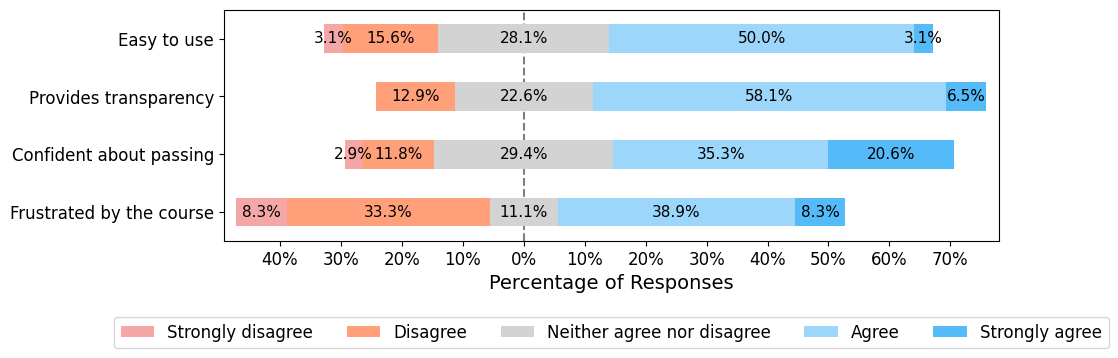

In [34]:
# Map categorical codes (AO01-AO05) to numeric Likert scores 1-5
mapping = {'AO01': 1.0, 'AO02': 2.0, 'AO03': 3.0, 'AO04': 4.0, 'AO05': 5.0}

# Recode each survey scale to numeric and ensure float dtype
post_survey_df['Usability']     = post_survey_df['Usability'].replace(mapping).astype(float)
post_survey_df['Transparency']  = post_survey_df['Transparency'].replace(mapping).astype(float)
post_survey_df['Confidence']    = post_survey_df['Confidence'].replace(mapping).astype(float)
post_survey_df['Frustration']   = post_survey_df['Frustration'].replace(mapping).astype(float)

# Keep only respondents with interaction == "yes" (case-insensitive) and select target columns -> only students who interacted with a system can tell us about their perception of it
data = post_survey_df.loc[
    post_survey_df["interaction"].astype(str).str.lower().eq("yes"),
    ["Usability", "Transparency", "Confidence", "Frustration"]
].copy()

label_map = {
    "Usability": "Easy to use",
    "Transparency": "Provides transparency",
    "Confidence": "Confident about passing",
    "Frustration": "Frustrated by the course"
}

# Apply renaming to the dataframe
data = data.rename(columns=label_map)

# Draw the Likert chart using the helper defined earlier
plot_likert(data)

#### Frustration and Confidence Relationship

To better understand the intriguing tension between frustration and confidence reported in the survey, we examine the relationship between these two constructs. This analysis helps clarify whether frustration stems from the tool itself or from the inherent difficulty of the course content, and how the tool may support self-efficacy despite challenging course demands.

##### Correlation Analysis

First, we examine the correlation between Confidence and Frustration scores to understand whether these constructs are inversely related, independent, or show a different pattern.

In [35]:
# Prepare data for correlation analysis
# Use the same filtered data as the Likert plot (interaction == "yes")
correlation_data = post_survey_df.loc[
    post_survey_df["interaction"].astype(str).str.lower().eq("yes"),
    ["user_id", "Confidence", "Frustration", "Usability", "Transparency"],
].copy()

# Remove any rows with missing values in the correlation variables
correlation_data = correlation_data.dropna(subset=["Confidence", "Frustration", "Usability", "Transparency"])

# Calculate Spearman correlation (appropriate for Likert scale data)
correlation_result = pg.corr(
    correlation_data['Confidence'], 
    correlation_data['Frustration'],
    method='spearman'
)

print("Spearman Correlation between Confidence and Frustration:")
print(correlation_result)
print(f"\nInterpretation:")
print(f"  - Spearman's ρ = {correlation_result['r'].values[0]:.3f}")
print(f"  - p-value = {correlation_result['p-val'].values[0]:.4f}")
print(f"  - n = {correlation_result['n'].values[0]}")

if correlation_result['p-val'].values[0] < 0.05:
    if abs(correlation_result['r'].values[0]) < 0.3:
        strength = "weak"
    elif abs(correlation_result['r'].values[0]) < 0.5:
        strength = "moderate"
    else:
        strength = "strong"
    
    direction = "negative" if correlation_result['r'].values[0] < 0 else "positive"
    print(f"\nThere is a statistically significant {strength} {direction} correlation between Confidence and Frustration.")
else:
    print(f"\nNo statistically significant correlation between Confidence and Frustration was found.")

Spearman Correlation between Confidence and Frustration:
           n         r          CI95%     p-val     power
spearman  29 -0.454138  [-0.7, -0.11]  0.013335  0.717307

Interpretation:
  - Spearman's ρ = -0.454
  - p-value = 0.0133
  - n = 29

There is a statistically significant moderate negative correlation between Confidence and Frustration.


##### Cross-Tabulation of High Confidence and High Frustration

Next, we examine how many students simultaneously report both high confidence (agree or strongly agree) and high frustration (agree or strongly agree), which represents the core of the "intriguing tension" noted in the results.

In [36]:
# Create binary variables for high confidence and high frustration
# High = Agree (4) or Strongly Agree (5)
correlation_data['high_confidence'] = correlation_data['Confidence'] >= 4
correlation_data['high_frustration'] = correlation_data['Frustration'] >= 4

# Create cross-tabulation
crosstab = pd.crosstab(
    correlation_data['high_confidence'],
    correlation_data['high_frustration'],
    margins=True,
    margins_name='Total'
)

# Rename index and columns for clarity
crosstab.index = ['Low/Neutral Confidence', 'High Confidence', 'Total']
crosstab.columns = ['Low/Neutral Frustration', 'High Frustration', 'Total']

print("Cross-Tabulation of Confidence and Frustration:")
print(crosstab)
print()

# Calculate key statistics
total_n = len(correlation_data)
high_conf_high_frust = ((correlation_data['high_confidence']) & (correlation_data['high_frustration'])).sum()
high_conf_total = correlation_data['high_confidence'].sum()
high_frust_total = correlation_data['high_frustration'].sum()

print(f"Key Findings:")
print(f"  - Total respondents: {total_n}")
print(f"  - Students with high confidence: {high_conf_total} ({high_conf_total/total_n*100:.1f}%)")
print(f"  - Students with high frustration: {high_frust_total} ({high_frust_total/total_n*100:.1f}%)")
print(f"  - Students with BOTH high confidence AND high frustration: {high_conf_high_frust} ({high_conf_high_frust/total_n*100:.1f}%)")
print()
print(f"Among students with high confidence, {high_conf_high_frust}/{high_conf_total} ({high_conf_high_frust/high_conf_total*100:.1f}%) also report high frustration.")
print(f"This demonstrates that confidence and frustration can coexist, suggesting frustration may be")
print(f"related to course difficulty rather than lack of self-efficacy or tool usability issues.")

Cross-Tabulation of Confidence and Frustration:
                        Low/Neutral Frustration  High Frustration  Total
Low/Neutral Confidence                        5                 8     13
High Confidence                              12                 4     16
Total                                        17                12     29

Key Findings:
  - Total respondents: 29
  - Students with high confidence: 16 (55.2%)
  - Students with high frustration: 12 (41.4%)
  - Students with BOTH high confidence AND high frustration: 4 (13.8%)

Among students with high confidence, 4/16 (25.0%) also report high frustration.
This demonstrates that confidence and frustration can coexist, suggesting frustration may be
related to course difficulty rather than lack of self-efficacy or tool usability issues.


##### Relationship with Tool Usability

To determine whether frustration is related to the tool or the course content, we examine the relationship between frustration and perceived tool usability. If frustration is independent of usability ratings, this suggests frustration stems from course difficulty rather than tool-related issues.

In [37]:
# Correlation between Frustration and Usability
frust_usability_corr = pg.corr(
    correlation_data['Frustration'],
    correlation_data['Usability'],
    method='spearman'
)

print("Spearman Correlation between Frustration and Usability:")
print(frust_usability_corr)
print()

# Correlation between Frustration and Transparency
frust_transparency_corr = pg.corr(
    correlation_data['Frustration'],
    correlation_data['Transparency'],
    method='spearman'
)

print("Spearman Correlation between Frustration and Transparency:")
print(frust_transparency_corr)
print()

# Summary interpretation
print("Summary:")
print(f"  - Frustration × Usability: ρ = {frust_usability_corr['r'].values[0]:.3f}, p = {frust_usability_corr['p-val'].values[0]:.4f}")
print(f"  - Frustration × Transparency: ρ = {frust_transparency_corr['r'].values[0]:.3f}, p = {frust_transparency_corr['p-val'].values[0]:.4f}")
print()

if (frust_usability_corr['p-val'].values[0] > 0.05) and (frust_transparency_corr['p-val'].values[0] > 0.05):
    print("Interpretation: Frustration shows no significant correlation with tool usability or transparency.")
    print("This indicates that frustration is likely related to course difficulty rather than tool-related issues,")
    print("supporting the conclusion that Atlas provides usable, transparent support even in a challenging learning environment.")
elif abs(frust_usability_corr['r'].values[0]) < 0.3 and abs(frust_transparency_corr['r'].values[0]) < 0.3:
    print("Interpretation: Frustration shows weak or no meaningful correlation with tool characteristics.")
    print("This suggests frustration is primarily driven by course content difficulty rather than the tool itself.")

Spearman Correlation between Frustration and Usability:
           n         r          CI95%     p-val     power
spearman  29  0.253415  [-0.12, 0.57]  0.184699  0.267936

Spearman Correlation between Frustration and Transparency:
           n         r          CI95%     p-val     power
spearman  29 -0.113802  [-0.46, 0.26]  0.556667  0.090402

Summary:
  - Frustration × Usability: ρ = 0.253, p = 0.1847
  - Frustration × Transparency: ρ = -0.114, p = 0.5567

Interpretation: Frustration shows no significant correlation with tool usability or transparency.
This indicates that frustration is likely related to course difficulty rather than tool-related issues,
supporting the conclusion that Atlas provides usable, transparent support even in a challenging learning environment.


##### Interaction Group Comparison

Finally, we examine whether the relationship between confidence and frustration varies across interaction groups (High, Low, No). This helps understand whether different levels of engagement with Atlas relate to different patterns of confidence and frustration.

In [38]:
# Merge interaction group into correlation data
correlation_with_group = correlation_data.merge(
    post_survey_df[['user_id', 'interaction_group']].drop_duplicates(),
    on='user_id',
    how='left'
)

# Descriptive statistics by interaction group
print("Mean Confidence and Frustration by Interaction Group:")
print("=" * 70)
group_stats = correlation_with_group.groupby('interaction_group')[['Confidence', 'Frustration']].agg(['mean', 'std', 'count'])
print(group_stats.round(2))
print()

# Test if there are significant differences in Confidence across groups
if correlation_with_group['interaction_group'].notna().any():
    kruskal_confidence = pg.kruskal(
        data=correlation_with_group.dropna(subset=['interaction_group']),
        dv='Confidence',
        between='interaction_group'
    )
    
    kruskal_frustration = pg.kruskal(
        data=correlation_with_group.dropna(subset=['interaction_group']),
        dv='Frustration',
        between='interaction_group'
    )
    
    print("Kruskal-Wallis Test Results:")
    print("-" * 70)
    print(f"Confidence across interaction groups: H = {kruskal_confidence['H'].values[0]:.3f}, p = {kruskal_confidence['p-unc'].values[0]:.4f}")
    print(f"Frustration across interaction groups: H = {kruskal_frustration['H'].values[0]:.3f}, p = {kruskal_frustration['p-unc'].values[0]:.4f}")
    print()
    
    if kruskal_confidence['p-unc'].values[0] > 0.05 and kruskal_frustration['p-unc'].values[0] > 0.05:
        print("Interpretation: No significant differences in confidence or frustration across interaction groups.")
        print("This suggests that the confidence-frustration pattern is consistent regardless of")
        print("engagement level with Atlas, further supporting that frustration relates to course")
        print("difficulty rather than tool engagement patterns.")
    else:
        print("Interpretation: Some differences exist across interaction groups.")
        print("Further post-hoc analysis would be needed to identify specific group differences.")

Mean Confidence and Frustration by Interaction Group:
                  Confidence             Frustration            
                        mean   std count        mean   std count
interaction_group                                               
High                    3.65  0.93    20        3.10  1.02    20
Low                     3.44  1.33     9        2.67  1.41     9

Kruskal-Wallis Test Results:
----------------------------------------------------------------------
Confidence across interaction groups: H = 0.049, p = 0.8250
Frustration across interaction groups: H = 0.889, p = 0.3457

Interpretation: No significant differences in confidence or frustration across interaction groups.
This suggests that the confidence-frustration pattern is consistent regardless of
engagement level with Atlas, further supporting that frustration relates to course
difficulty rather than tool engagement patterns.


## Inferential Analysis
This section contains the hypothesis tests and functions to interpret the results in natural language.

### Functions for Hypothesis Testing
Functions that are useful for multiple hypothesis tests are defined once here.

#### Functions for Interpretation of Statistical Results in Natural Language
For better readability of the results, we provide functions that turn statistical test results into plain-English summaries.

In [39]:
def interpret_kruskal_result(kruskal_df, alpha=0.05):
    """
    Generate a plain-English summary of a Kruskal-Wallis test result.

    Parameters
    ----------
    kruskal_df : pd.DataFrame
        DataFrame with the test output (e.g., from pingouin.kruskal), expected to
        contain at least the columns: 'H' (test statistic), 'p-unc' (p-value),
        and 'ddof1' (degrees of freedom, typically k-1 groups).
        Only the first row is used.
    alpha : float, default 0.05
        Significance threshold for deciding whether the effect is statistically significant.

    Returns
    -------
    str
        A human-readable interpretation including H, df, p, and a significance statement.
    """
    # Extract key statistics from the first row
    H = kruskal_df.iloc[0]['H']
    p = kruskal_df.iloc[0]['p-unc']
    df = int(kruskal_df.iloc[0]['ddof1'])

    # Build a formatted report string
    interpretation = f"Kruskal-Wallis test:\n"
    interpretation += f"  - H = {H:.3f}\n"
    interpretation += f"  - df = {df}\n"
    interpretation += f"  - p = {p:.4f}\n\n"

    # Decision based on alpha
    if p < alpha:
        interpretation += "There is a significant difference between at least two groups."
    else:
        interpretation += "There is no significant difference between the groups."

    return interpretation


In [40]:
def interpret_dunn_posthoc_results(posthoc_df, alpha=0.05):
    """
    Generate a plain-English summary of Dunn post hoc pairwise comparisons.

    Parameters
    ----------
    posthoc_df : pd.DataFrame
        Output from `pingouin.pairwise_tests` (or similar) after a Kruskal-Wallis test,
        expected to contain at least:
          - 'A' and 'B' : names/labels of the two groups being compared
          - 'p-corr'    : multiplicity-adjusted p-value (e.g., Bonferroni, Holm)
    alpha : float, default 0.05
        Significance threshold used to flag comparisons as significant.

    Returns
    -------
    str
        A multi-line string summarizing each pairwise comparison with its
        adjusted p-value and a significance marker.
    """
    lines = ["Interpretation of Dunn Posthoc Test:\n"]

    # Iterate over each pairwise comparison and format its result
    for _, row in posthoc_df.iterrows():
        group_a = row['A']
        group_b = row['B']
        p_corr = row['p-corr']  # adjusted p-value for multiple comparisons

        # Mark comparison as significant if p < alpha
        sig = "Significant" if p_corr < alpha else "Not significant"

        lines.append(f"- {group_a} vs {group_b}: p = {p_corr:.4f} → {sig}")

    return "\n".join(lines)



In [41]:
def interpret_pairwise_results(results: pd.DataFrame, alpha: float = 0.05, use_holm: bool = True) -> str:
    """
    Turn a pairwise comparison table into a plain-language summary.

    Expected columns in `results`
    -----------------------------
    - 'contrast' : string labels like 'high>no', 'high>low', 'low>no', or 'A vs B'
    - 'p1', 'p2' : pass rates as proportions (e.g., 0.42)
    - 'RR'       : risk ratio
    - 'OR'       : odds ratio
    - 'p_unadj'  : unadjusted p-value
    - 'p_holm'   : Holm-adjusted p-value

    Parameters
    ----------
    results : pd.DataFrame
        Pairwise comparison metrics as above.
    alpha : float, default 0.05
        Significance threshold.
    use_holm : bool, default True
        If True, decisions use Holm-adjusted p-values; otherwise unadjusted p.

    Returns
    -------
    str
        A multi-line string with bullet-point interpretations and a short takeaway.
    """
    # Helpers: percent formatting, compact p-value, rounding
    def pp(x):   # format proportion as percentage with 1 decimal
        return f"{x*100:.1f}%"
    def pval(x):  # compact p-value, e.g., p=.0284
        return f"p={x:.4f}".replace("0.", ".")
    def rnd(x, d=2):
        return f"{x:.{d}f}"

    # Choose which p-value to use and its label
    pcol = 'p_holm' if use_holm else 'p_unadj'
    label_p = "Holm-adjusted p" if use_holm else "p"

    lines = []
    sig_flags = []

    for _, row in results.iterrows():
        contrast = str(row['contrast'])

        # Parse group labels and the comparison direction from 'contrast'
        if '>' in contrast:
            g1, g2 = contrast.split('>')
            direction = "higher pass rate than"
        elif 'vs' in contrast:
            g1, g2 = [s.strip() for s in contrast.split('vs')]
            direction = "different pass rate than"
        else:
            # Fallback parsing if a custom separator is used
            parts = contrast.replace(' ', '').split(',')
            g1, g2 = parts[0], parts[1] if len(parts) > 1 else ("Group1", "Group2")
            direction = "higher pass rate than"

        # Extract metrics for this pair
        p1 = float(row['p1']); p2 = float(row['p2'])
        rd = p1 - p2                          # risk difference
        rr = float(row['RR'])                 # risk ratio
        or_ = float(row['OR'])                # odds ratio
        p_used = float(row[pcol])             # chosen p-value

        # Significance decision
        sig = p_used < alpha
        sig_flags.append(sig)

        verdict = "Significant" if sig else "Not significant"
        arrow = "↑" if rd > 0 else ("↓" if rd < 0 else "→")

        # Build the line with metrics and a brief interpretation
        lines.append(
            f"- **{g1} vs {g2}**: {arrow} {pp(p1)} vs {pp(p2)} "
            f"(Δ={pp(rd)}, RR={rnd(rr,2)}, OR={rnd(or_,2)}, {label_p} {pval(p_used)}) — {verdict}."
            + (f" Interpretation: **{g1}** has a {pp(rd)} higher value than **{g2}**."
               if sig and rd > 0 else
               f" Interpretation: no reliable evidence that **{g1}** has a higher value than **{g2}**.")
        )

    # Overall takeaway summarizing how many contrasts are significant
    n_sig = sum(sig_flags)
    if n_sig == 0:
        takeaway = f"No pairwise difference is significant at α={alpha:.2f}" + (" (Holm-adjusted)." if use_holm else ".")
    elif n_sig == 1:
        idx = sig_flags.index(True)
        cn = results.iloc[idx]['contrast']
        takeaway = f"Only **{cn}** is significant at α={alpha:.2f}" + (" (Holm-adjusted)." if use_holm else ".")
    else:
        sig_list = ", ".join(f"**{results.iloc[i]['contrast']}**" for i, s in enumerate(sig_flags) if s)
        takeaway = f"Significant differences at α={alpha:.2f}: {sig_list}" + (" (Holm-adjusted)." if use_holm else ".")

    header = f"Pairwise interpretation ({label_p}, α={alpha:.2f}):"
    return "\n".join([header, *lines, "", f"**Takeaway:** {takeaway}"])


#### Statistical Test for pairwise comparison of portions

In [42]:
def test_percentage_pairs(data: pd.DataFrame, column, one_sided: bool = True) -> pd.DataFrame:
    """
    Compare proportions (share of True) between interaction groups using z-tests,
    and report effect sizes (RR, OR) with Holm-adjusted p-values.

    Parameters
    ----------
    data : pd.DataFrame
        Must contain 'interaction_group' and the target `column`.
    column : str
        Column with boolean condition (or values convertible to bool) indicating "success".
    one_sided : bool, default True
        If True, tests H1: p_g1 > p_g2 (alternative='larger'); otherwise two-sided.

    Returns
    -------
    pd.DataFrame
        Rows for the pairs High>Low, High>No, Low>No with:
        ['contrast','p1','p2','RR','OR','z','p_unadj','p_holm'] (rounded to 4 d.p.).
    """
    # Cross-tab: rows = interaction_group, columns = boolean outcome (False/True)
    # Reindex to fixed order and fill missing with 0
    ct = (pd.crosstab(data['interaction_group'], data[column].astype(bool))
            .reindex(['No','Low','High'], fill_value=0))

    # Define pairwise comparisons (order matters for one-sided tests)
    pairs = [('High','Low'), ('High','No'), ('Low','No')]
    alt   = 'larger' if one_sided else 'two-sided'

    rows = []
    for g1, g2 in pairs:
        # Group totals and number of successes (True)
        n1, n2 = ct.loc[g1].sum(), ct.loc[g2].sum()
        x1, x2 = int(ct.loc[g1, True]), int(ct.loc[g2, True])

        # Two-proportion z-test (statsmodels.stats.proportion.proportions_ztest)
        z, p = proportions_ztest([x1, x2], [n1, n2], alternative=alt)

        # 2x2 table for effect sizes (statsmodels.stats.contingency_tables.Table2x2)
        t = Table2x2(np.array([[x1, n1 - x1],
                               [x2, n2 - x2]], float))

        rows.append({
            'contrast': f'{g1}>{g2}' if one_sided else f'{g1} vs {g2}',
            'p1': x1 / n1,
            'p2': x2 / n2,
            'RR': t.riskratio,
            'OR': t.oddsratio,
            'z': z,
            'p_unadj': float(p)
        })

    out = pd.DataFrame(rows)

    # Family-wise error control across the three tests (Holm step-down)
    out['p_holm'] = multipletests(out['p_unadj'], method='holm')[1]

    return out[['contrast', 'p1', 'p2', 'RR', 'OR', 'z', 'p_unadj', 'p_holm']].round(4)


### Mastery Score

In [43]:
# Add mastery score and mastery progress to competency_user_df
mastery_df = competency_user_df.merge(
    competency_df[["id", "mastery_threshold"]],
    left_on="competency_id",
    right_on="id",
    how="left"
)

# Calculate mastery score
mastery_df["mastery"] = (mastery_df["progress"] * mastery_df["confidence"]).clip(lower=0, upper=100)

# Add score to the data frame
mastery_df["mastery_progress"] = (mastery_df["mastery"] / mastery_df["mastery_threshold"]).clip(lower=0, upper=1)

# Only consider the first time that users reach their maximum mastery progress
# Search for index of maximum mastery progress per user
idx = full_df.groupby('user_id')['mastery_progress'].idxmax()

# Filter the DataFrame to only include these rows
max_mastery_per_user = full_df.loc[idx].sort_values('user_id').reset_index(drop=True)

In [44]:
# Kruskal-Wallis-Test
kruskal = pg.kruskal(
    data=max_mastery_per_user,
    dv='mastery_progress',
    between='interaction_group'
)

print("\nKruskal-Wallis Result:")
print(kruskal)
print(interpret_kruskal_result(kruskal))



Kruskal-Wallis Result:
                    Source  ddof1           H         p-unc
Kruskal  interaction_group      2  249.049219  8.310922e-55
Kruskal-Wallis test:
  - H = 249.049
  - df = 2
  - p = 0.0000

There is a significant difference between at least two groups.


In [45]:
# Non-parametric Posthoc — Dunn's Test
posthoc = pg.pairwise_tests(
    data=max_mastery_per_user,
    dv='mastery_progress',
    between='interaction_group',
    parametric=False,
    padjust='bonferroni'
)

print("\nDunn Posthoc Test Result:")
print(posthoc)
print(interpret_dunn_posthoc_results(posthoc))


Dunn Posthoc Test Result:
            Contrast     A    B  Paired  Parametric     U-val alternative  \
0  interaction_group  High  Low   False       False   52059.0   two-sided   
1  interaction_group  High   No   False       False  141590.0   two-sided   
2  interaction_group   Low   No   False       False  154824.5   two-sided   

          p-unc        p-corr    p-adjust    hedges  
0  3.731082e-04  1.119324e-03  bonferroni  0.319545  
1  4.454070e-41  1.336221e-40  bonferroni  1.068387  
2  1.586476e-29  4.759429e-29  bonferroni  0.814376  
Interpretation of Dunn Posthoc Test:

- High vs Low: p = 0.0011 → Significant
- High vs No: p = 0.0000 → Significant
- Low vs No: p = 0.0000 → Significant


### Exam Score

In [46]:
# Kruskal-Wallis-Test
kruskal = pg.kruskal(
    data=users,
    dv='total_exam_score',
    between='interaction_group'
)
print("\nKruskal-Wallis Result:")
print(kruskal)
print(interpret_kruskal_result(kruskal))


Kruskal-Wallis Result:
                    Source  ddof1          H     p-unc
Kruskal  interaction_group      2  13.616913  0.001104
Kruskal-Wallis test:
  - H = 13.617
  - df = 2
  - p = 0.0011

There is a significant difference between at least two groups.


In [47]:
# Non-parametric Posthoc — Dunn's Test
posthoc = pg.pairwise_tests(
    data=users,
    dv='total_exam_score',
    between='interaction_group',
    parametric=False,
    padjust='bonferroni'
)

print("\nDunn Posthoc Test Result:")
print(posthoc)
print(interpret_dunn_posthoc_results(posthoc))


Dunn Posthoc Test Result:
            Contrast     A    B  Paired  Parametric    U-val alternative  \
0  interaction_group  High  Low   False       False  33240.5   two-sided   
1  interaction_group  High   No   False       False  49746.5   two-sided   
2  interaction_group   Low   No   False       False  53414.5   two-sided   

      p-unc    p-corr    p-adjust    hedges  
0  0.874347  1.000000  bonferroni -0.000190  
1  0.001563  0.004689  bonferroni  0.262763  
2  0.002141  0.006423  bonferroni  0.257098  
Interpretation of Dunn Posthoc Test:

- High vs Low: p = 1.0000 → Not significant
- High vs No: p = 0.0047 → Significant
- Low vs No: p = 0.0064 → Significant


### Passing Rate

In [48]:
# Test for statistical significance of differences in passing rates
result = test_percentage_pairs(users, 'passed', one_sided=True)
print(result)
print(interpret_pairwise_results(result))

   contrast      p1      p2      RR      OR       z  p_unadj  p_holm
0  High>Low  0.5547  0.5281  1.0503  1.1130  0.6039   0.2730  0.2730
1   High>No  0.5547  0.4571  1.2133  1.4790  2.3469   0.0095  0.0284
2    Low>No  0.5281  0.4571  1.1552  1.3289  1.7468   0.0403  0.0807
Pairwise interpretation (Holm-adjusted p, α=0.05):
- **High vs Low**: ↑ 55.5% vs 52.8% (Δ=2.7%, RR=1.05, OR=1.11, Holm-adjusted p p=.2730) — Not significant. Interpretation: no reliable evidence that **High** has a higher value than **Low**.
- **High vs No**: ↑ 55.5% vs 45.7% (Δ=9.8%, RR=1.21, OR=1.48, Holm-adjusted p p=.0284) — Significant. Interpretation: **High** has a 9.8% higher value than **No**.
- **Low vs No**: ↑ 52.8% vs 45.7% (Δ=7.1%, RR=1.16, OR=1.33, Holm-adjusted p p=.0807) — Not significant. Interpretation: no reliable evidence that **Low** has a higher value than **No**.

**Takeaway:** Only **High>No** is significant at α=0.05 (Holm-adjusted).


### Practice Mode

In [49]:
# Create per-user test run counts for statistical analysis
test_runs_per_user = (
    participation_df[participation_df['test_run'] == True]
    .groupby(['interaction_group', 'user_id'], as_index=False)
    .size()
    .rename(columns={'size': 'test_run_count'})
)

print("\nTest runs per user (sample):")
print(test_runs_per_user.head(10))
print(f"\nTotal users with at least one test run: {len(test_runs_per_user)}")

# Descriptive statistics by group
print("\nDescriptive statistics by interaction group:")
print(test_runs_per_user.groupby('interaction_group')['test_run_count'].describe().round(2))


Test runs per user (sample):
  interaction_group                               user_id  test_run_count
0              High  01569517-4b65-4997-8e27-d73e941fd0e9               4
1              High  015edf02-7436-433f-8eff-c7dd4f993a35              19
2              High  02976030-7063-4677-89e5-944403d7753a              19
3              High  073a6c37-afbb-4bed-8e17-011c96b6b556              12
4              High  086fc9a0-c8b9-4667-a404-8900d8021e0a               9
5              High  0b0f0df5-d413-4ed4-a7b8-09ba0239b8b5               6
6              High  0e464494-7ece-4cd0-a971-47132e21eb0c               5
7              High  0f113635-bab1-44a9-a014-7824cd78279d               1
8              High  11cb1dde-5c05-447e-8daa-20044fc12700              31
9              High  1441df5b-c842-4467-a9b7-7e8bea9c5790               5

Total users with at least one test run: 618

Descriptive statistics by interaction group:
                   count   mean   std  min  25%   50%    75%   ma

In [50]:
# Kruskal-Wallis test for practice mode usage
kruskal = pg.kruskal(
    data=test_runs_per_user,
    dv='test_run_count',
    between='interaction_group'
)

print("\nKruskal-Wallis Result for Practice Mode:")
print(kruskal)
print(interpret_kruskal_result(kruskal))


Kruskal-Wallis Result for Practice Mode:
                    Source  ddof1         H     p-unc
Kruskal  interaction_group      2  4.411189  0.110185
Kruskal-Wallis test:
  - H = 4.411
  - df = 2
  - p = 0.1102

There is no significant difference between the groups.


In [51]:
# Non-parametric Post-hoc — Dunn's Test for practice mode
posthoc = pg.pairwise_tests(
    data=test_runs_per_user,
    dv='test_run_count',
    between='interaction_group',
    parametric=False,
    padjust='bonferroni'
)

print("\nDunn Posthoc Test Result for Practice Mode:")
print(posthoc)
print(interpret_dunn_posthoc_results(posthoc))


Dunn Posthoc Test Result for Practice Mode:
            Contrast     A    B  Paired  Parametric    U-val alternative  \
0  interaction_group  High  Low   False       False  20422.5   two-sided   
1  interaction_group  High   No   False       False  24095.5   two-sided   
2  interaction_group   Low   No   False       False  24053.5   two-sided   

      p-unc    p-corr    p-adjust    hedges  
0  0.525985  1.000000  bonferroni  0.086445  
1  0.046784  0.140352  bonferroni  0.183309  
2  0.140095  0.420284  bonferroni  0.101808  
Interpretation of Dunn Posthoc Test:

- High vs Low: p = 1.0000 → Not significant
- High vs No: p = 0.1404 → Not significant
- Low vs No: p = 0.4203 → Not significant


In [52]:
# COMMENTED OUT - This test was incorrect (used proportions instead of count data)
# Use the Kruskal-Wallis test cells above instead
# 
# # Test for statistical significance of differences in handed in test runs
# result = test_percentage_pairs(participation_df, 'test_run', one_sided=True)
# print(result)
# print(interpret_pairwise_results(result))

### Learning Path Started

In [53]:
# Test for statistical significance of differences in the percentage of users who started the learning path
result = test_percentage_pairs(learning_path_df, 'started_by_student', one_sided=True)
print(result)
print(interpret_pairwise_results(result))

   contrast      p1      p2      RR      OR       z  p_unadj  p_holm
0  High>Low  0.4982  0.3040  1.6391  2.2738  4.8957   0.0000  0.0000
1   High>No  0.4982  0.1946  2.5601  4.1091  9.4640   0.0000  0.0000
2    Low>No  0.3040  0.1946  1.5618  1.8072  3.8535   0.0001  0.0001
Pairwise interpretation (Holm-adjusted p, α=0.05):
- **High vs Low**: ↑ 49.8% vs 30.4% (Δ=19.4%, RR=1.64, OR=2.27, Holm-adjusted p p=.0000) — Significant. Interpretation: **High** has a 19.4% higher value than **Low**.
- **High vs No**: ↑ 49.8% vs 19.5% (Δ=30.4%, RR=2.56, OR=4.11, Holm-adjusted p p=.0000) — Significant. Interpretation: **High** has a 30.4% higher value than **No**.
- **Low vs No**: ↑ 30.4% vs 19.5% (Δ=10.9%, RR=1.56, OR=1.81, Holm-adjusted p p=.0001) — Significant. Interpretation: **Low** has a 10.9% higher value than **No**.

**Takeaway:** Significant differences at α=0.05: **High>Low**, **High>No**, **Low>No** (Holm-adjusted).


### Learning Path Interactions

In [54]:
# Kruskal-Wallis-Test
kruskal = pg.kruskal(
    data=lp_interactions_per_user,
    dv='interactions',
    between='interaction_group'
)

print("\nKruskal-Wallis Result:")
print(kruskal)
print(interpret_kruskal_result(kruskal))


Kruskal-Wallis Result:
                    Source  ddof1          H         p-unc
Kruskal  interaction_group      2  75.870353  3.349362e-17
Kruskal-Wallis test:
  - H = 75.870
  - df = 2
  - p = 0.0000

There is a significant difference between at least two groups.


In [55]:
# Non-parametric Posthoc — Dunn's Test (not Tukey)
posthoc = pg.pairwise_tests(
    data=lp_interactions_per_user,
    dv='interactions',
    between='interaction_group',
    parametric=False,
    padjust='bonferroni'
)

print("\nDunn Posthoc Test Result:")
print(posthoc)
print(interpret_dunn_posthoc_results(posthoc))


Dunn Posthoc Test Result:
            Contrast     A    B  Paired  Parametric    U-val alternative  \
0  interaction_group  High  Low   False       False  38051.5   two-sided   
1  interaction_group  High   No   False       False  48508.0   two-sided   
2  interaction_group   Low   No   False       False  40454.5   two-sided   

          p-unc        p-corr    p-adjust    hedges  
0  1.312379e-08  3.937137e-08  bonferroni  0.229885  
1  2.745333e-17  8.236000e-17  bonferroni  0.438033  
2  1.990080e-03  5.970239e-03  bonferroni  0.163616  
Interpretation of Dunn Posthoc Test:

- High vs Low: p = 0.0000 → Significant
- High vs No: p = 0.0000 → Significant
- Low vs No: p = 0.0060 → Significant
